In [1]:
# São Luís - Ridge Regression

In [2]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 6,4
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (6,4)})
import warnings
warnings.simplefilter(action='ignore')

In [3]:
df = pd.read_excel(r"SaoLuis_ML_Std.xls")
df.head()

,SPD,CV,Price_sd,Price_skewness,Price_kurtosis,Cartel_SL
0,-1.512210,-1.415126,-1.523575,0.530595,-0.372297,1
1,-1.590998,-1.423813,-1.531361,0.465319,-0.465210,1
2,-1.472599,-1.390720,-1.500943,0.277075,-0.523992,1
3,-1.891792,-1.794681,-1.874691,0.988610,-0.150930,1
4,-1.512210,-1.424056,-1.531331,-0.390301,-0.859725,1


In [4]:
# Predicting Cartel
# define X and y
X = df.drop("Cartel_SL",axis = 1)
y = df.Cartel_SL

In [5]:
X.head()

,SPD,CV,Price_sd,Price_skewness,Price_kurtosis
0,-1.512210,-1.415126,-1.523575,0.530595,-0.372297
1,-1.590998,-1.423813,-1.531361,0.465319,-0.465210
2,-1.472599,-1.390720,-1.500943,0.277075,-0.523992
3,-1.891792,-1.794681,-1.874691,0.988610,-0.150930
4,-1.512210,-1.424056,-1.531331,-0.390301,-0.859725


In [6]:
#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [7]:
# grid search hyperparameters for Ridge regression
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2')
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
# define grid
grid = dict()
grid['C'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring="accuracy", cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('accuracy: %.3f' % results.best_score_)
print('Best value for C: %s' % results.best_params_)

accuracy: 0.953
Best value for C: {'C': 0.89}


In [8]:
logreg = LogisticRegression(penalty='l2', C= 0.89)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.89)

In [9]:
print(logreg.coef_, logreg.intercept_)

[[ 0.94439819  4.14500993 -5.72259477  0.2882512  -0.01227391]] [-0.53577597]


In [10]:
# make class predictions for the testing set
y_pred = logreg.predict(X_test)

In [11]:
#calculate the percentage of ones
Percentage_of_ones = y_test.mean()
print('Null Accuracy:', Percentage_of_ones)

Null Accuracy: 0.5111111111111111


In [12]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
#mean_squared_error(y_test, y_pred_class)

0.9777777777777777


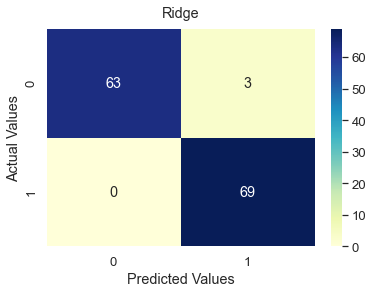

In [13]:
import seaborn as sns
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.2) # Adjust to fit
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Ridge', y=1.025)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig('CM_Ridge_SaoLuis.png', dpi=600)

In [14]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        66
           1       0.96      1.00      0.98        69

    accuracy                           0.98       135
   macro avg       0.98      0.98      0.98       135
weighted avg       0.98      0.98      0.98       135



In [15]:
# store the predicted probabilities for class 1
from sklearn.metrics import roc_curve
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

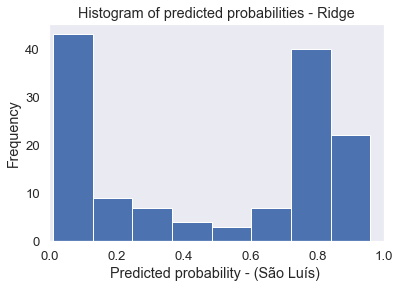

In [16]:
# histogram of predicted probabilities
plt.hist(y_pred_proba, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities - Ridge')
plt.xlabel('Predicted probability - (São Luís) ')
plt.ylabel('Frequency')
plt.grid(False)
plt.savefig('Histogram_Ridge_SaoLuis.png', dpi=600)

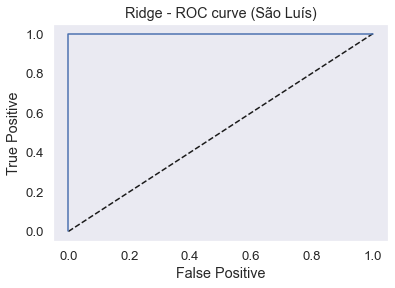

In [17]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('Ridge - ROC curve (São Luís)')
plt.grid(False)
sns.set_style("ticks")
plt.savefig('ROC_Ridge_SaoLuis.png', dpi=600)

In [18]:
from sklearn.metrics import roc_curve
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [19]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
auc = cross_val_score(logreg, X_test, y_test, cv=5, scoring='roc_auc').mean()
print('AUC:',auc)

AUC: 0.976923076923077


In [20]:
import eli5
from eli5.sklearn import PermutationImportance

In [21]:
perm = PermutationImportance(logreg, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.5244 ± 0.0481,Price_sd
0.2696 ± 0.0333,CV
0.0859 ± 0.0575,SPD
0.0030 ± 0.0119,Price_skewness
0 ± 0.0000,Price_kurtosis


In [22]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('sensitivity:', tpr[thresholds > threshold][-1])
    print('specificity:', 1 - fpr[thresholds > threshold][-1])

In [23]:
evaluate_threshold(0.5)

sensitivity: 1.0
specificity: 1.0


In [24]:
evaluate_threshold(0.6)

sensitivity: 1.0
specificity: 1.0


In [25]:
evaluate_threshold(0.7)

sensitivity: 0.014492753623188406
specificity: 1.0


In [26]:
evaluate_threshold(0.8)

sensitivity: 0.014492753623188406
specificity: 1.0


In [27]:
evaluate_threshold(0.9)

sensitivity: 0.014492753623188406
specificity: 1.0


In [28]:
evaluate_threshold(0.99)

sensitivity: 0.0
specificity: 1.0
